mark

In [1]:
from tensorflow.signal import fft

from tensorflow.keras.layers import Lambda
from tensorflow.signal import fft, fft2d, fftshift, ifft2d, ifft2d

import tensorflow

import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# from skimage.transform import resize

from xrdc.source_separation import *
from skimage.transform import resize
from tensorflow.signal import fft2d, fftshift

N = 28
    
padx = pady = N // 2
def do_resize():
    #padx = pady = x.shape[1] // 2
    transform = tfkl.AveragePooling2D(2)
    padder = tfkl.ZeroPadding2D((padx // 2, padx // 2))
    return tfk.Sequential([
        transform,
        padder
    ])

def do_forward():
    sequential = do_resize()
    sequential.add(Lambda(lambda resized: (fft2d(
        tf.squeeze(tf.cast(resized, tf.complex64))
    ))))
    sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
    sequential.add(Lambda(lambda psd: 
                          tf.expand_dims(
                              tf.math.sqrt(
            fftshift(psd, (-2, -1))
                                    ), 3)))
    return sequential

def resize(x):
    rmod = do_resize()
    rmod.compile(loss = 'mse')
    return rmod.predict(x)

rmod = do_forward()
rmod.compile(loss='mse')
#rmod.fit(x)

2022-08-30 21:35:06.013316: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 21:35:06.014347: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
from xrdc import fourier

In [104]:
rmod.predict(x).shape

(10, 28, 28, 1)

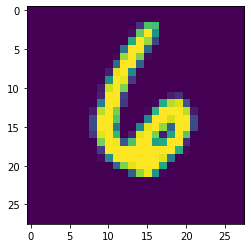

In [46]:
plt.imshow(np.array(x).squeeze()[0])

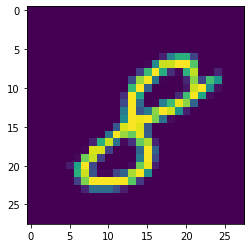

In [505]:
plt.imshow(np.array(x).squeeze()[3])

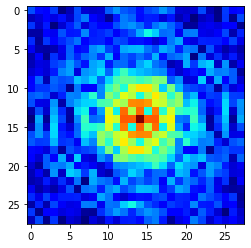

In [579]:
arg0 = fourier.fftshift(power(fourier.fft2((np.array(x).squeeze()[1]))))
plt.imshow(
    np.log(1 + arg0)
, cmap = 'jet')

In [667]:
tmp = ((fourier.fft2((np.array(x).squeeze()[1]))))

In [668]:
mask = (np.abs(fourier.fftfreq(28)) > .25)

In [662]:
tmp[mask, :] = 0

tmp[:, mask] = 0

from scipy.fftpack import ifftshift as sifftshift

In [669]:
tmp2 = (power(fourier.ifft2((tmp))))

In [670]:
tmp2.mean(), np.array(x).squeeze()[1].mean()

(0.22483566, 0.24898957)

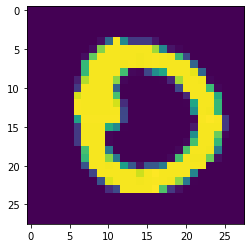

In [671]:
plt.imshow(tmp2)

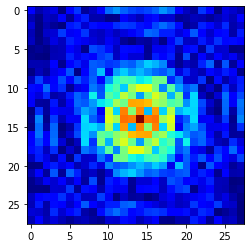

In [672]:
plt.imshow(np.log(4 + power(fourier.fftshift(fourier.fft2(tmp2)))), cmap = 'jet')

In [514]:
resize(x)

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00


1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00


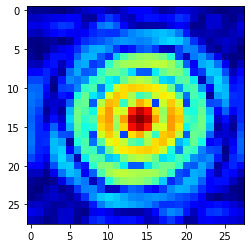

In [658]:
arg = fourier.fftshift(power(fourier.fft2((np.array(
        resize(x)
    ).squeeze()[1]))))
plt.imshow(
    np.log(1 + 
           arg
          )
, cmap = 'jet')

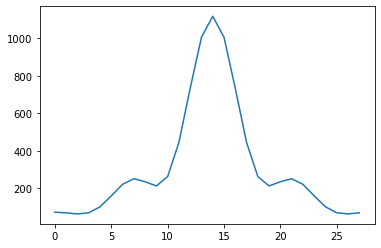

In [526]:
plt.plot(arg.sum(axis = 0))

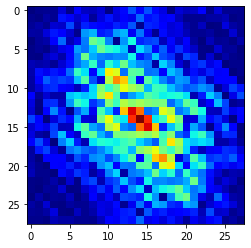

In [548]:
arg2 = fourier.fftshift(power(fourier.fft2((np.array(
        x
    ).squeeze()[3]))))
plt.imshow(
    np.log(4 + 
           arg2
          )
, cmap = 'jet')

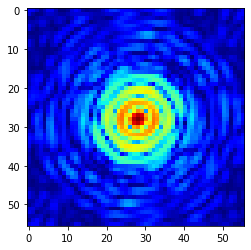

In [577]:
arg3 = fourier.fftshift(power(fourier.fft2(
    np.pad(np.array(x)[1].squeeze(), 14)
    )))

plt.imshow(
    np.log(4 + 
           arg3
          )
, cmap = 'jet')

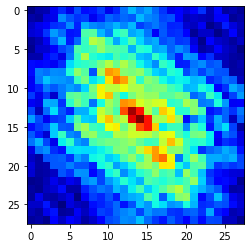

In [564]:
arg4 = arg3[0::2, 0::2] + arg3[0::2, 1::2] + arg3[1::2, 0::2] + arg3[1::2, 1::2]
plt.imshow(
    np.log(4 + 
           arg4
          )
, cmap = 'jet')

In [390]:
ifftshift

<function numpy.fft.ifftshift(x, axes=None)>

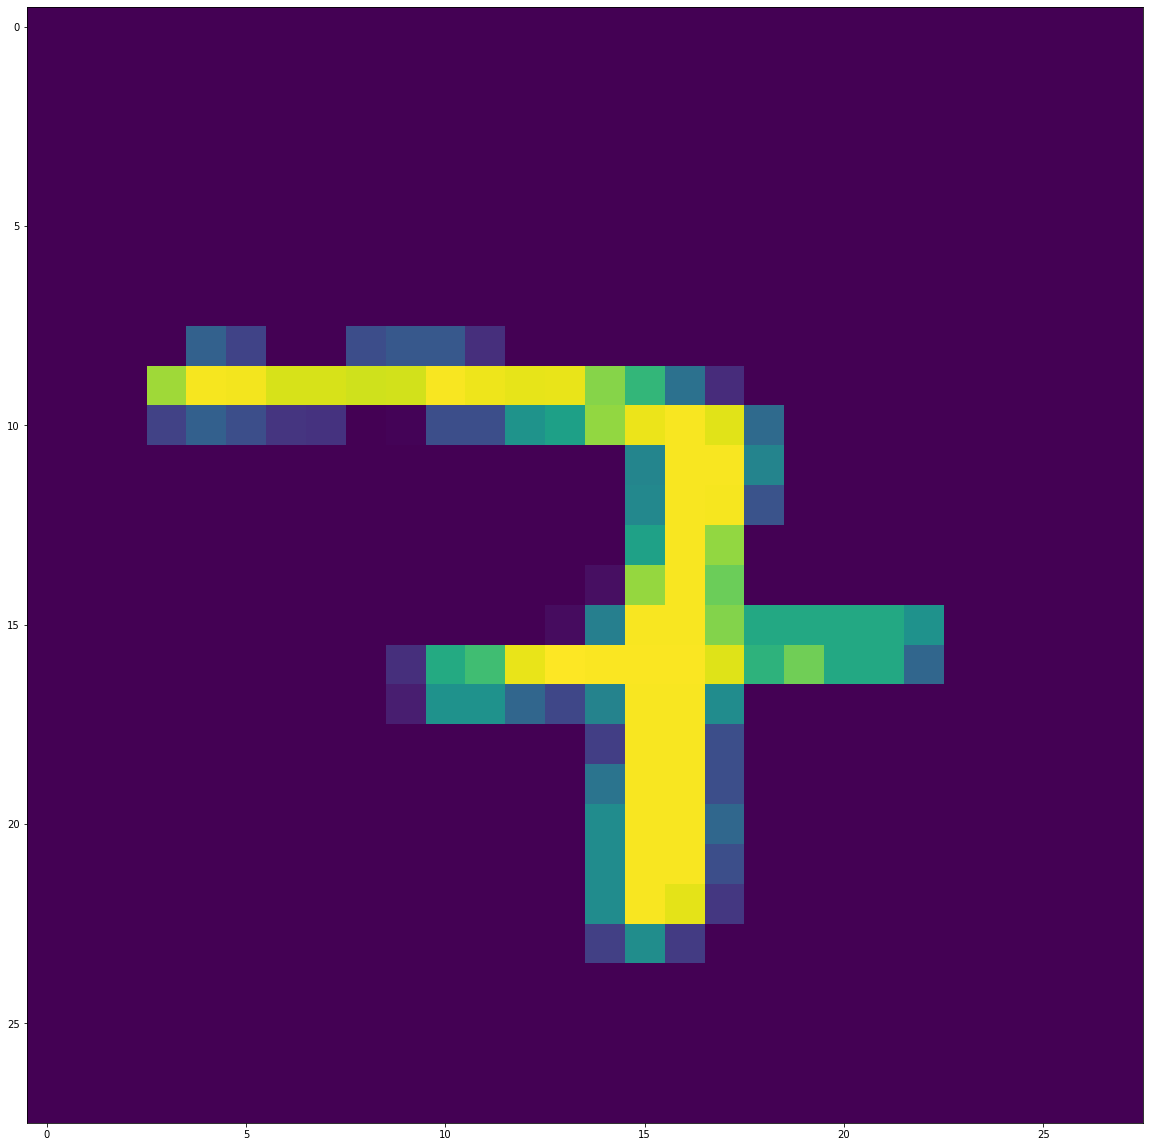

In [384]:
plt.imshow(np.array(x_orig)[3].squeeze())

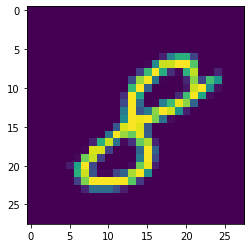

In [538]:
plt.imshow(np.array(x)[3].squeeze())

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00


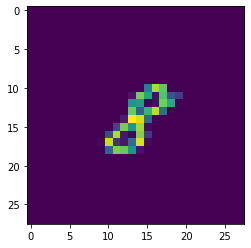

In [539]:
plt.imshow(np.array(resize(x))[3].squeeze())

In [535]:
np.sum(x)

1248.9922

In [533]:
np.sum(resize(x))

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00


312.24805

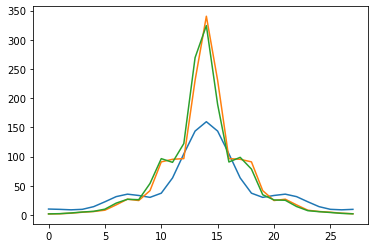

In [561]:
plt.plot(4 * arg.mean(axis = 0))
plt.plot(arg2.mean(axis = 0))
# plt.plot(arg3.mean(axis = 0))
plt.plot(arg4.mean(axis = 0) / 4)

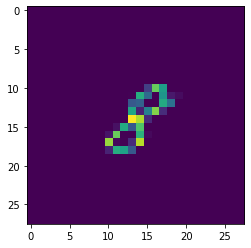

In [484]:
plt.imshow(power(np.array(rmod.predict(x)[3]).squeeze()))

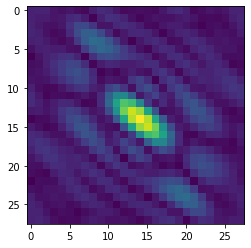

In [487]:
plt.imshow((np.array(rmod.predict(x)[3]).squeeze()))

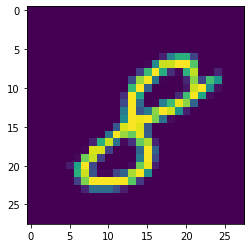

In [394]:
plt.imshow(np.array(x[3]).squeeze())

In [3]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print(cuda_version)

KeyError: 'cuda_version'

In [4]:
cudnn_version = sys_details["cudnn_version"]  
print(cudnn_version)

KeyError: 'cudnn_version'

In [9]:
# tf.debugging.set_log_device_placement(False)

In [147]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
#     image = tf.squeeze(
#         do_forward(
#             image[None, ...]),
#         axis = 0)
    #image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
    #image = tf.expand_dims(image, 0)
    #print(image.shape)

    rmod = do_forward()
    rmod.compile(loss='mse')
    orig = tf.identity(image)
    image = rmod(image)#rmod.predict(image)
    return image, image, orig

train_dataset = (datasets['train']
                 .batch(256)
                 .map(_preprocess)
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .batch(256)
                .map(_preprocess)
                .prefetch(tf.data.AUTOTUNE))

In [148]:
x = next(iter(eval_dataset))[0][:10]

In [79]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

In [80]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [198]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])


In [325]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
#     tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
#                 padding='same', activation=None),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=tf.nn.sigmoid),
    tfkl.Reshape(input_shape),
    #Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    
])

decoder2 = tfk.Sequential([
    tfkl.InputLayer(input_shape = tf.TensorShape([None, None, None])),
    do_forward(),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.003))),
])


In [326]:
# vae = tfk.Model(inputs=encoder.inputs,
#                 outputs=decoder(encoder.outputs[0]))

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder2(decoder(encoder.outputs[0])))

In [327]:
for layer in decoder.layers:
    print(layer.output_shape)

(None, 1, 1, 16)
(None, 1, 1, 16)
(None, 7, 7, 64)
(None, 7, 7, 64)
(None, 14, 14, 64)
(None, 14, 14, 32)
(None, 28, 28, 32)
(None, 28, 28, 32)
(None, 28, 28, 32)
(None, 28, 28, 1)
(None, 28, 28, 1)


In [345]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negloglik)

In [353]:
_ = vae.fit(train_dataset,
            epochs=4,
            validation_data=eval_dataset)

Epoch 1/4
235/235 [==============================] - 180s 730ms/step - loss: 4600.7432 - val_loss: 4568.2896
Epoch 2/4
235/235 [==============================] - 180s 734ms/step - loss: 4571.3931 - val_loss: 4400.0786
Epoch 3/4
235/235 [==============================] - 177s 712ms/step - loss: 4405.7915 - val_loss: 4360.3760
Epoch 4/4
235/235 [==============================] - 177s 717ms/step - loss: 4385.3643 - val_loss: 4451.7388


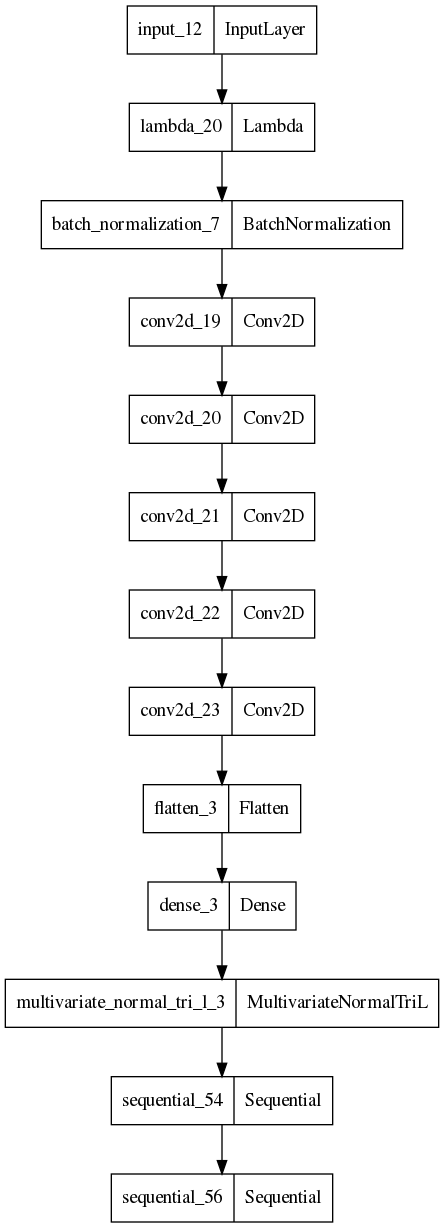

In [125]:
tf.keras.utils.plot_model(vae, 'foo.png')

In [355]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(np.log(.01 + x[i].squeeze()), interpolation='none', cmap='jet')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

In [90]:
# print('Originals:')
# display_imgs(x)

# print('Decoded Random Samples:')
# display_imgs(xhat.sample())

# print('Decoded Modes:')
# display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

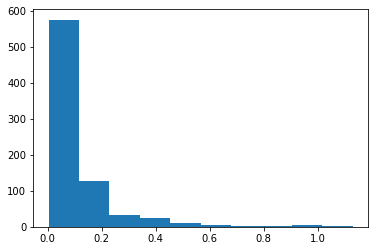

In [91]:
plt.hist(np.array(tf.squeeze(x[5])).ravel());

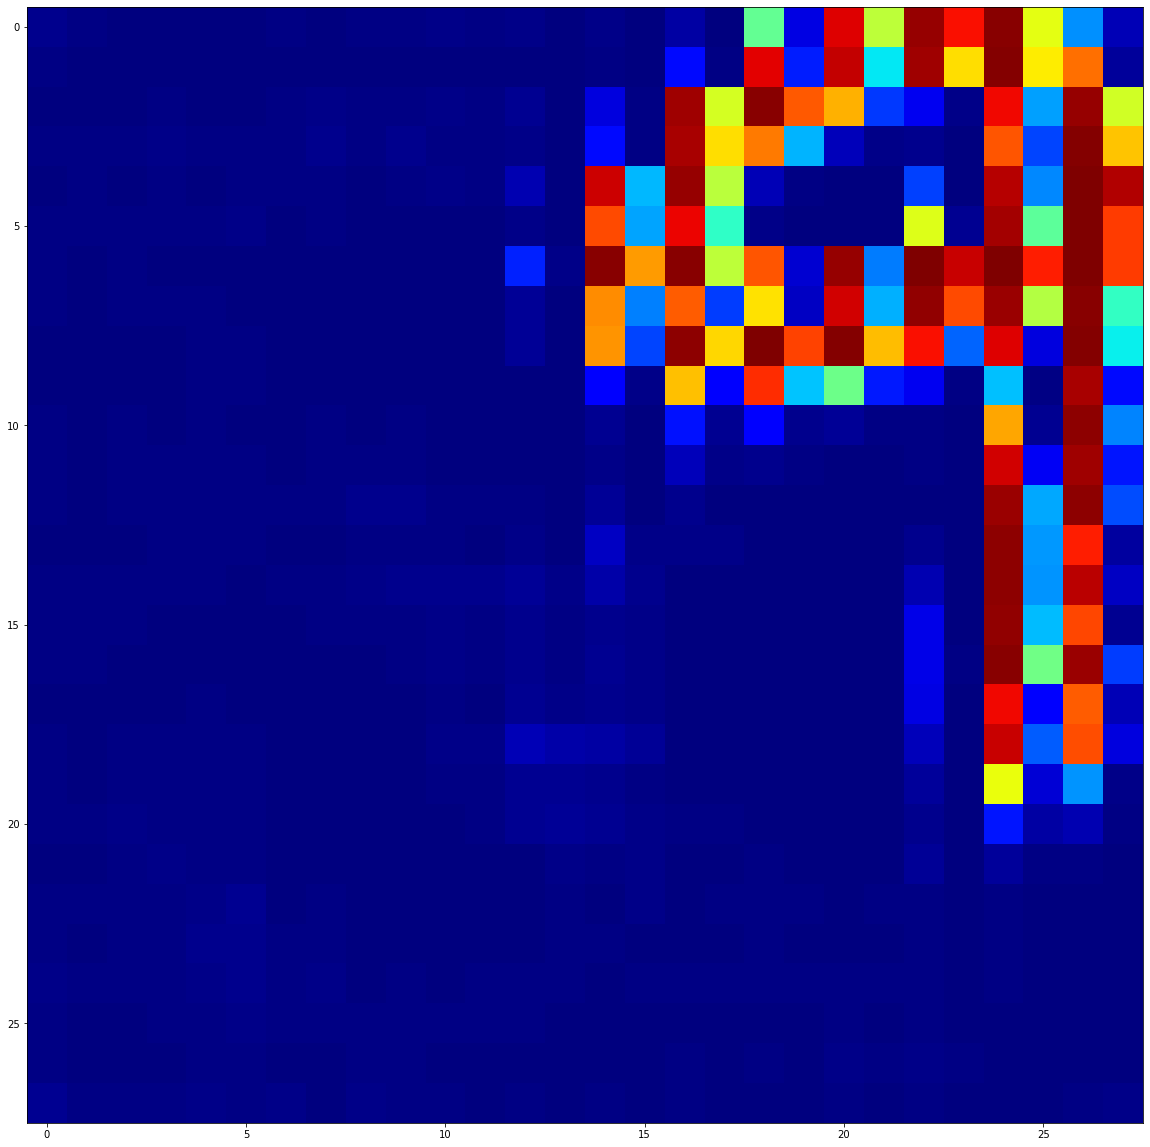

In [393]:
# plt.imshow(np.array((decoder(encoder(x)))).squeeze()[4], cmap = 'jet')

# plt.imshow(np.array(resize((x_orig))).squeeze()[2], cmap = 'jet')

# plt.imshow(np.array(resize(decoder(encoder(x)))).squeeze()[2], cmap = 'jet')

In [397]:
# plt.imshow(np.array(decoder2(decoder(encoder(x))).mean()).squeeze()[0], cmap = 'jet')

Originals:


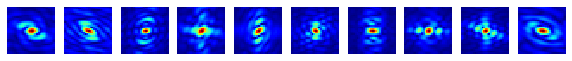

Decoded Random Samples:


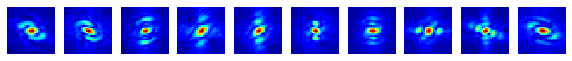

Decoded Modes:


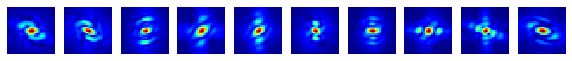

Decoded Means:


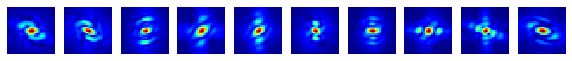

In [206]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

Originals:


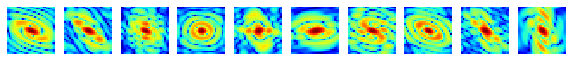

Decoded Random Samples:


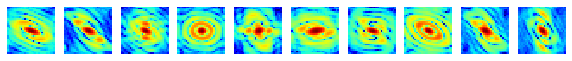

Decoded Modes:


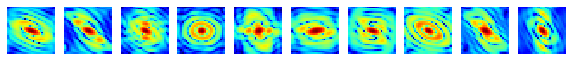

Decoded Means:


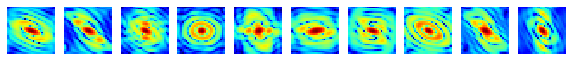

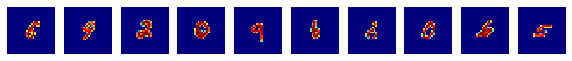

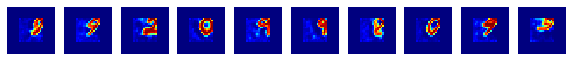

In [392]:
x_orig = next(iter(eval_dataset))[2][10:20]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][10:20]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 30)

print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

display_imgs(resize(x_orig))

display_imgs(resize(decoder(encoder(x).mode())))

In [380]:
decoder(encoder(x).mode())

<tf.Tensor: shape=(10, 28, 28, 1), dtype=float32, numpy=
array([[[[1.27292871e-02],
         [4.16120887e-03],
         [9.04142857e-04],
         ...,
         [3.27547193e-02],
         [1.08909607e-03],
         [6.97374344e-04]],

        [[5.73751330e-03],
         [1.76784396e-03],
         [6.31779432e-04],
         ...,
         [7.93268085e-02],
         [3.35338712e-03],
         [1.33365393e-04]],

        [[2.58126855e-03],
         [2.81596184e-03],
         [1.16413832e-03],
         ...,
         [9.41534996e-01],
         [5.06622314e-01],
         [5.29663861e-02]],

        ...,

        [[4.20925021e-03],
         [1.86604261e-03],
         [9.62495804e-04],
         ...,
         [1.17295980e-03],
         [8.45164061e-04],
         [1.47411227e-03]],

        [[5.10910153e-03],
         [1.97833776e-03],
         [1.57529116e-03],
         ...,
         [7.57008791e-04],
         [1.38345361e-03],
         [3.83901596e-03]],

        [[1.60835683e-02],
         [6.

In [360]:
mkdir models/mnist_fourier_vae/

In [362]:
import dill

In [364]:
vae.save('models/mnist_fourier_vae/vae.h5')

In [365]:
encoder.save('models/mnist_fourier_vae/encoder.h5')

In [366]:
decoder.save('models/mnist_fourier_vae/decoder.h5')

In [367]:
decoder2.save('models/mnist_fourier_vae/decoder2.h5')

In [338]:
np.max(decoder(encoder(x)))

0.9977344

In [223]:
np.max(decoder(encoder(x)))

1.0

In [357]:
mkdir models

Randomly Generated Samples:


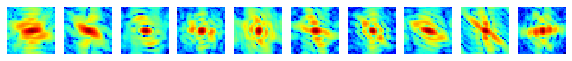

Randomly Generated Modes:


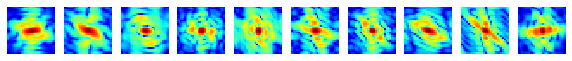

Randomly Generated Means:


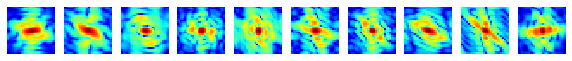

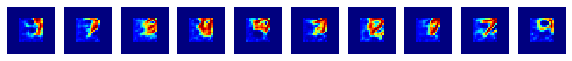

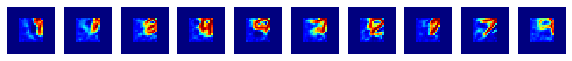

In [352]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder2(decoder(z))
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
samp = xtilde.sample()
display_imgs(samp)

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

display_imgs(resize(decoder(z)))

display_imgs(resize(decoder(encoder(samp))))

In [286]:
np.percentile(np.sqrt(x), 30)

0.19483866989612575

Randomly Generated Samples:


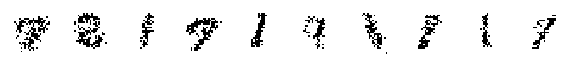

Randomly Generated Modes:


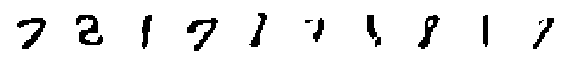

Randomly Generated Means:


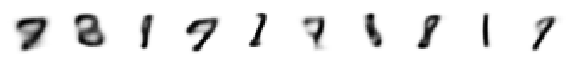

In [455]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

In [522]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [523]:
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [542]:
do_forward(nn.ZeroPad2d((0, 1, 0, 1))(x)).shape

torch.Size([16, 1, 29, 29])

In [543]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.Compose([transforms.ToTensor(),
                                nn.ZeroPad2d((0, 1, 0, 1)),
                                do_forward])
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [544]:
import torchvision

In [586]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, N**2)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.z_dim = z_dim
        
        base_depth = 32
        
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(1, 2 * base_depth, 7, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU())
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer6 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(base_depth, 1, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth)  
    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden)).reshape(-1, N, N)
        blur = torchvision.transforms.GaussianBlur(5, sigma=(.8, .8))

        return blur(loc_img)

In [587]:
import torch.nn.functional as F


In [588]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim = 7*7*16):
        super().__init__()
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.fc1 = nn.Linear(7*7*32, hidden_dim)

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU())
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU())
        
        
        
        # setup the three linear transformations used
        #self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x


        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #hidden = self.softplus(self.fc1(out))
        hidden = self.softplus(out)

#         # first shape the mini-batch to have pixels in the rightmost dimension
#         x = x.reshape(-1, 784)
        # then compute the hidden units
        #hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [589]:
obs_sigma = .05

# # define the model p(x|z)p(z)
# def model(self, x):
#     # register PyTorch module `decoder` with Pyro
#     pyro.module("decoder", self.decoder)
#     with pyro.plate("data", x.shape[0]):
#         # setup hyperparameters for prior p(z)
#         z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
#         z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
#         # sample from prior (value will be sampled by guide when computing the ELBO)
#         z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
#         # decode the latent code z
#         loc_img = self.decoder(z)
#         # score against actual images
#         #pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
#         pyro.sample("obs", dist.Normal(loc_img, obs_sigma).to_event(1), obs=x.reshape(-1, 784))

In [590]:
# # define the guide (i.e. variational distribution) q(z|x)
# def guide(self, x):
#     # register PyTorch module `encoder` with Pyro
#     pyro.module("encoder", self.encoder)
#     with pyro.plate("data", x.shape[0]):
#         # use the encoder to get the parameters used to define q(z|x)
#         z_loc, z_scale = self.encoder(x)
#         # sample the latent code z
#         pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [591]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=7*7*16, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        #x = do_forward(x)
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z

            loc_img = do_forward(
                    self.decoder(z)
                ).reshape(-1, N**2)
            # score against actual images
            #pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            return pyro.sample("obs", dist.Normal(loc_img, obs_sigma).to_event(1),
                               obs=x.reshape(-1, N**2))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        #x = do_forward(x)
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [592]:
do_forward(x[10]).max()

tensor(0.4922)

In [593]:
vae = VAE()

In [594]:
optimizer = Adam({"lr": 1.0e-3})

In [595]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [596]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [597]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [599]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 20
TEST_FREQUENCY = 5

In [600]:
N = 29

In [ ]:
from xrdc.source_separation import *

In [ ]:
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [510]:
# from skimage.transform import resize

# def do_resize(x):
#     padx = pady = x.shape[-1] // 2
#     transform = nn.AvgPool2d(2)
#     padder = nn.ZeroPad2d((padx // 2, padx // 2 + 1, padx // 2, padx // 2 + 1))
# #     resized = torch.nn.functional.pad(
# #             transform(x) / 4
# # #             resize(x, newshape)
# #         , p2d, "constant", 0)
#     resized = padder(
#         transform(x)
#     )
#     return resized

# def do_forward(x):
#     X = (fft.fft2(do_resize(x))) 
#     psd = torch.real(torch.conj(X) * X) / N**2
    
#     #return psd
#     amplitude = torch.sqrt(fft.fftshift(psd, (-1, -2)))
#     return amplitude
#     #return amplitude / torch.max(torch.max(amplitude, dim = -1).values, dim = -1).values[:, None, None]
# from torch import fft


# from torch import fft

# # plt.imshow(resized)

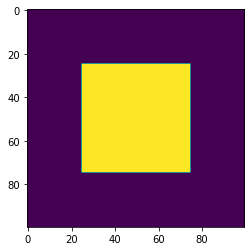

In [135]:
plt.imshow(do_resize(np.ones_like(arr)))

In [733]:
%pdb

Automatic pdb calling has been turned ON


In [750]:
do_forward(x)

tensor([[[[4.6791e-04, 4.5581e-04, 4.1331e-04,  ..., 3.3099e-04,
           4.1331e-04, 4.5581e-04],
          [3.2929e-04, 3.1233e-04, 2.8045e-04,  ..., 2.5971e-04,
           3.0697e-04, 3.3028e-04],
          [7.6540e-05, 6.7093e-05, 8.1178e-05,  ..., 7.0199e-05,
           8.2718e-05, 8.7515e-05],
          ...,
          [4.9072e-05, 7.4506e-05, 6.1123e-05,  ..., 2.1204e-04,
           5.7752e-05, 2.2651e-05],
          [7.6541e-05, 8.7515e-05, 8.2719e-05,  ..., 1.3504e-04,
           8.1177e-05, 6.7093e-05],
          [3.2929e-04, 3.3028e-04, 3.0697e-04,  ..., 2.2778e-04,
           2.8045e-04, 3.1233e-04]]],


        [[[1.1100e-03, 9.8271e-04, 6.5919e-04,  ..., 2.9786e-04,
           6.5919e-04, 9.8271e-04],
          [1.1219e-03, 9.5447e-04, 6.1333e-04,  ..., 2.1285e-04,
           6.0780e-04, 9.8800e-04],
          [1.0848e-03, 1.0064e-03, 6.6471e-04,  ..., 8.1590e-05,
           3.8125e-04, 8.1235e-04],
          ...,
          [8.7594e-04, 4.5448e-04, 1.4526e-04,  ..., 5.04

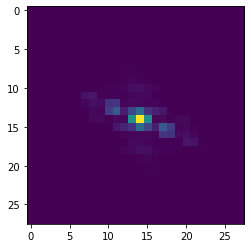

In [65]:
plt.imshow(
    fftshift(power(fft2(x[3][0].numpy()))))

In [706]:
N = 28

In [704]:
(resized * resized).mean()

0.020570649

In [786]:
do_resize(x[0][0]).mean()

tensor(0.0216)

In [143]:
do_forward(x).min()

tensor(0.0002)

In [142]:
x.max()

tensor(1.)

In [722]:
resized.mean()

0.029960735

In [771]:
do_forward(x).shape

torch.Size([16, 1, 28, 28])

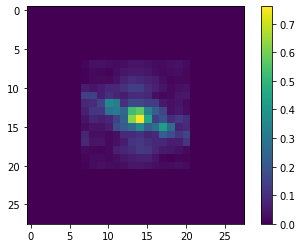

In [164]:
plt.imshow(do_resize(x)[3][0])
plt.colorbar()

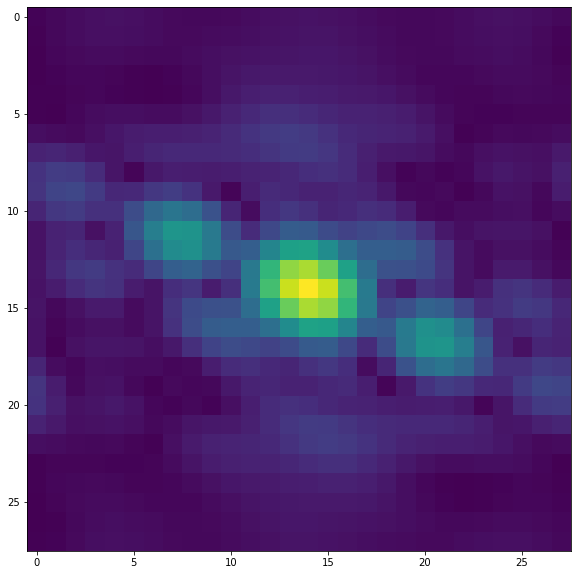

In [866]:
plt.imshow(do_forward(x)[3][0])

In [871]:
torch.__version__

'1.10.2+cu102'

In [868]:
x[3][0].shape

torch.Size([28, 28])

In [870]:
plt.imshow(do_forward(x[3][0]))

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got -3)

> /home/ollie/anaconda3/lib/python3.8/site-packages/torch/nn/modules/pooling.py(616)forward()
    614 
    615     def forward(self, input: Tensor) -> Tensor:
--> 616         return F.avg_pool2d(input, self.kernel_size, self.stride,
    617                             self.padding, self.ceil_mode, self.count_include_pad, self.divisor_override)
    618 

ipdb> c


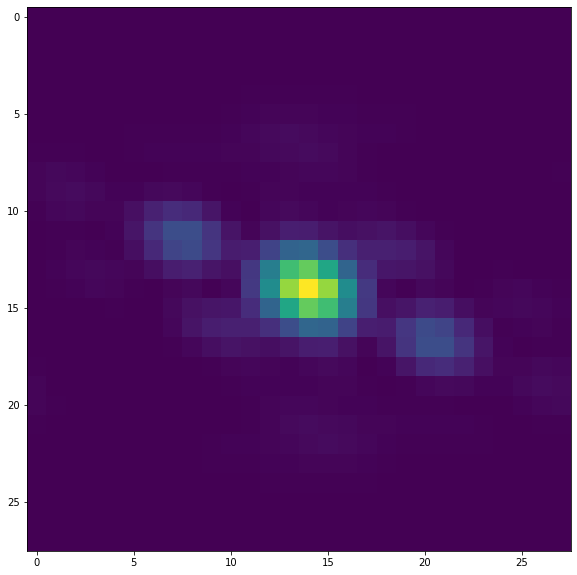

In [769]:
plt.imshow(do_forward(x[3][0]))

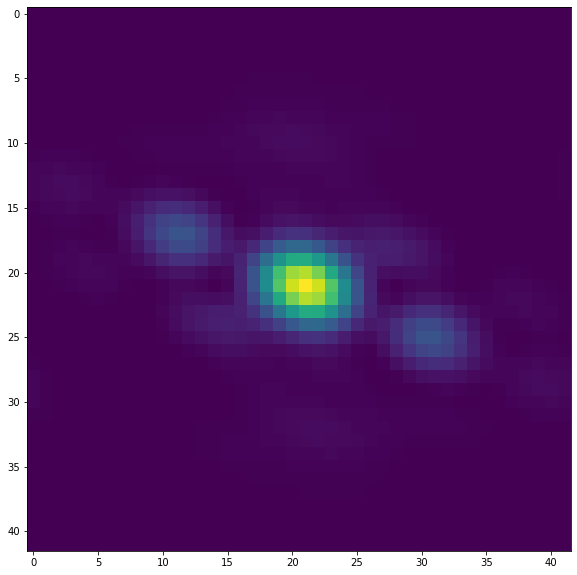

In [752]:
plt.imshow(do_forward(x[3][0]))

In [ ]:
(resized * resized)

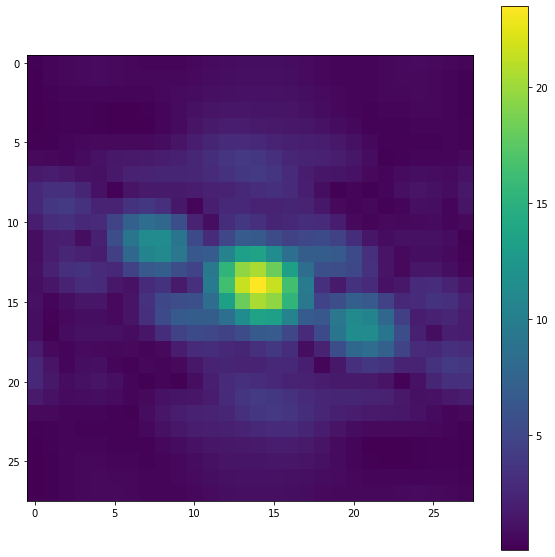

In [700]:
plt.imshow(
    fftshift(
        np.sqrt(power(fft2(resized)))))
plt.colorbar()

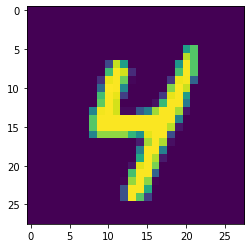

In [66]:
plt.imshow(x[3].reshape((28, 28)).detach().numpy())

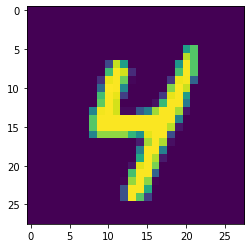

In [130]:
plt.imshow(x[3].reshape((28, 28)).detach().numpy())

In [602]:
plt.imshow(x.cpu()[3].reshape((28, 28)), cmap = 'jet')
plt.colorbar()

RuntimeError: shape '[28, 28]' is invalid for input of size 841

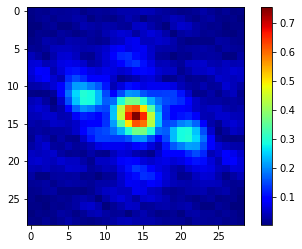

In [608]:
plt.imshow(do_forward(vae.reconstruct_img(x)).cpu().detach().numpy()[3], cmap = 'jet')
plt.colorbar()

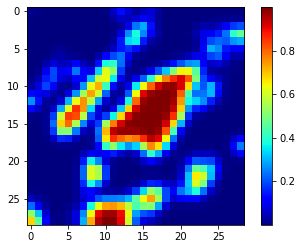

In [613]:
plt.imshow(vae.reconstruct_img(x)[15].reshape((N, N)).cpu().detach().numpy(), cmap = 'jet')
plt.colorbar()

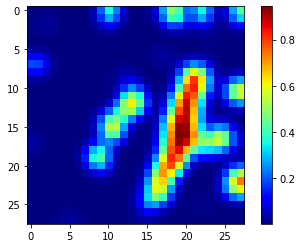

In [456]:
plt.imshow(vae.reconstruct_img(x)[3].reshape((28, 28)).cpu().detach().numpy(), cmap = 'jet')
plt.colorbar()

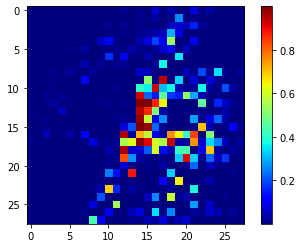

In [351]:
plt.imshow(vae.reconstruct_img(x)[3].reshape((28, 28)).detach().numpy(), cmap = 'jet')
plt.colorbar()

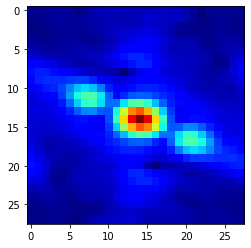

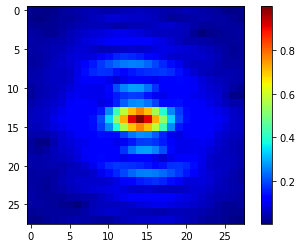

In [317]:
plt.imshow(vae.reconstruct_img(x)[2].reshape((28, 28)).detach().numpy(), cmap = 'jet')
plt.colorbar()

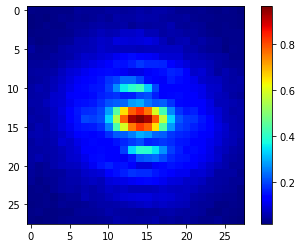

In [300]:
plt.imshow(vae.reconstruct_img(x)[2].reshape((28, 28)).detach().numpy(), cmap = 'jet')
plt.colorbar()

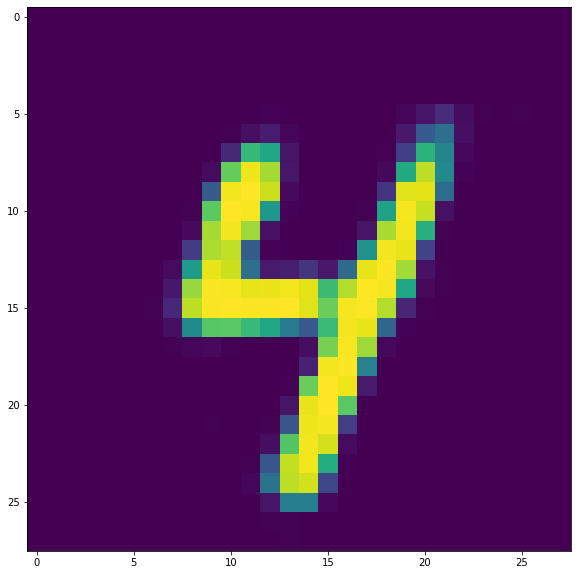

In [671]:
plt.imshow(vae.reconstruct_img(x)[3].reshape((28, 28)).detach().numpy())

In [637]:
# vae.reconstruct_img(x[0])[0].reshape((28, 28)).min()

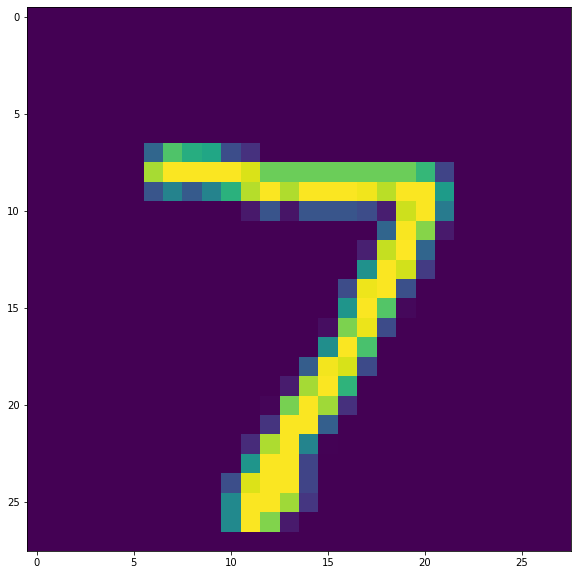

In [638]:
plt.imshow(res[0][0])

In [639]:
test_elbo

[169.84870153808595, 373.8694891296387, 402.4586141204834]

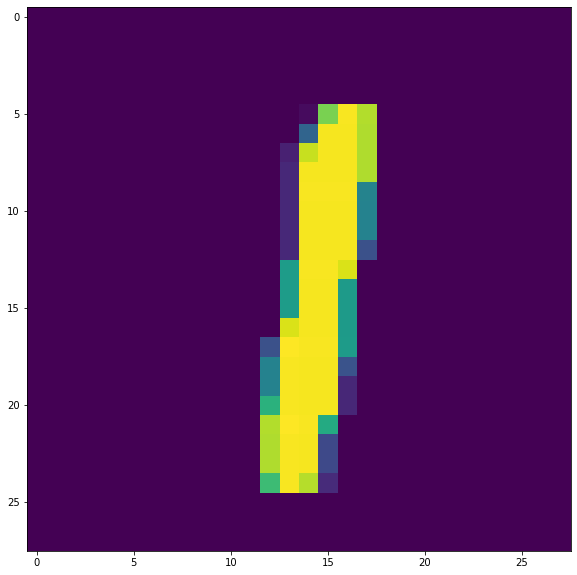

In [640]:
plt.imshow(x[0][0])